In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
photo_dir = r"D:\MATTHEW\GITHUB\Cycle GAN Implementation\dataset_testing\photo_1000_1"
monet_dir = r"D:\MATTHEW\Data Modelling\gan-getting-started\monet_jpg"

In [3]:
monet_generator = load_model("monet_generator_model.h5", compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})
photo_generator = load_model("photo_generator_model.h5", compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

C:\Users\matth\anaconda3\envs\gpu-py310-env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [4]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    image = np.array(image).astype(np.float32) / 127.5 - 1.0  # [-1, 1]
    return tf.expand_dims(image, axis=0)

def deprocess_image(image_tensor):
    image = (image_tensor + 1.0) * 127.5
    return tf.cast(image, tf.uint8).numpy()

In [5]:
def test_and_display(input_dir, model, direction="photo2monet", num_images=5):
    image_files = os.listdir(input_dir)
    selected_files = random.sample(image_files, num_images)

    plt.figure(figsize=(20, 10))
    ssim_scores = []

    for i, filename in enumerate(selected_files):
        input_path = os.path.join(input_dir, filename)
        input_image = preprocess_image(input_path)
        generated_image = model(input_image, training=False)

        input_display = deprocess_image(input_image[0]) / 255.0
        output_display = deprocess_image(generated_image[0]) / 255.0

        ssim_score = tf.image.ssim(input_display, output_display, max_val=1.0).numpy()
        ssim_percent = ssim_score * 100
        ssim_scores.append(ssim_percent)

        plt.subplot(2, num_images, i + 1)
        plt.imshow(input_display)
        title = "Input Photo" if direction == "photo2monet" else "Input Monet"
        plt.title(title, fontsize=16)
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(output_display)
        out_title = "Generated Monet" if direction == "photo2monet" else "Generated Photo"
        plt.title(f"{out_title}\nSSIM: {ssim_percent:.2f}%", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    return ssim_scores

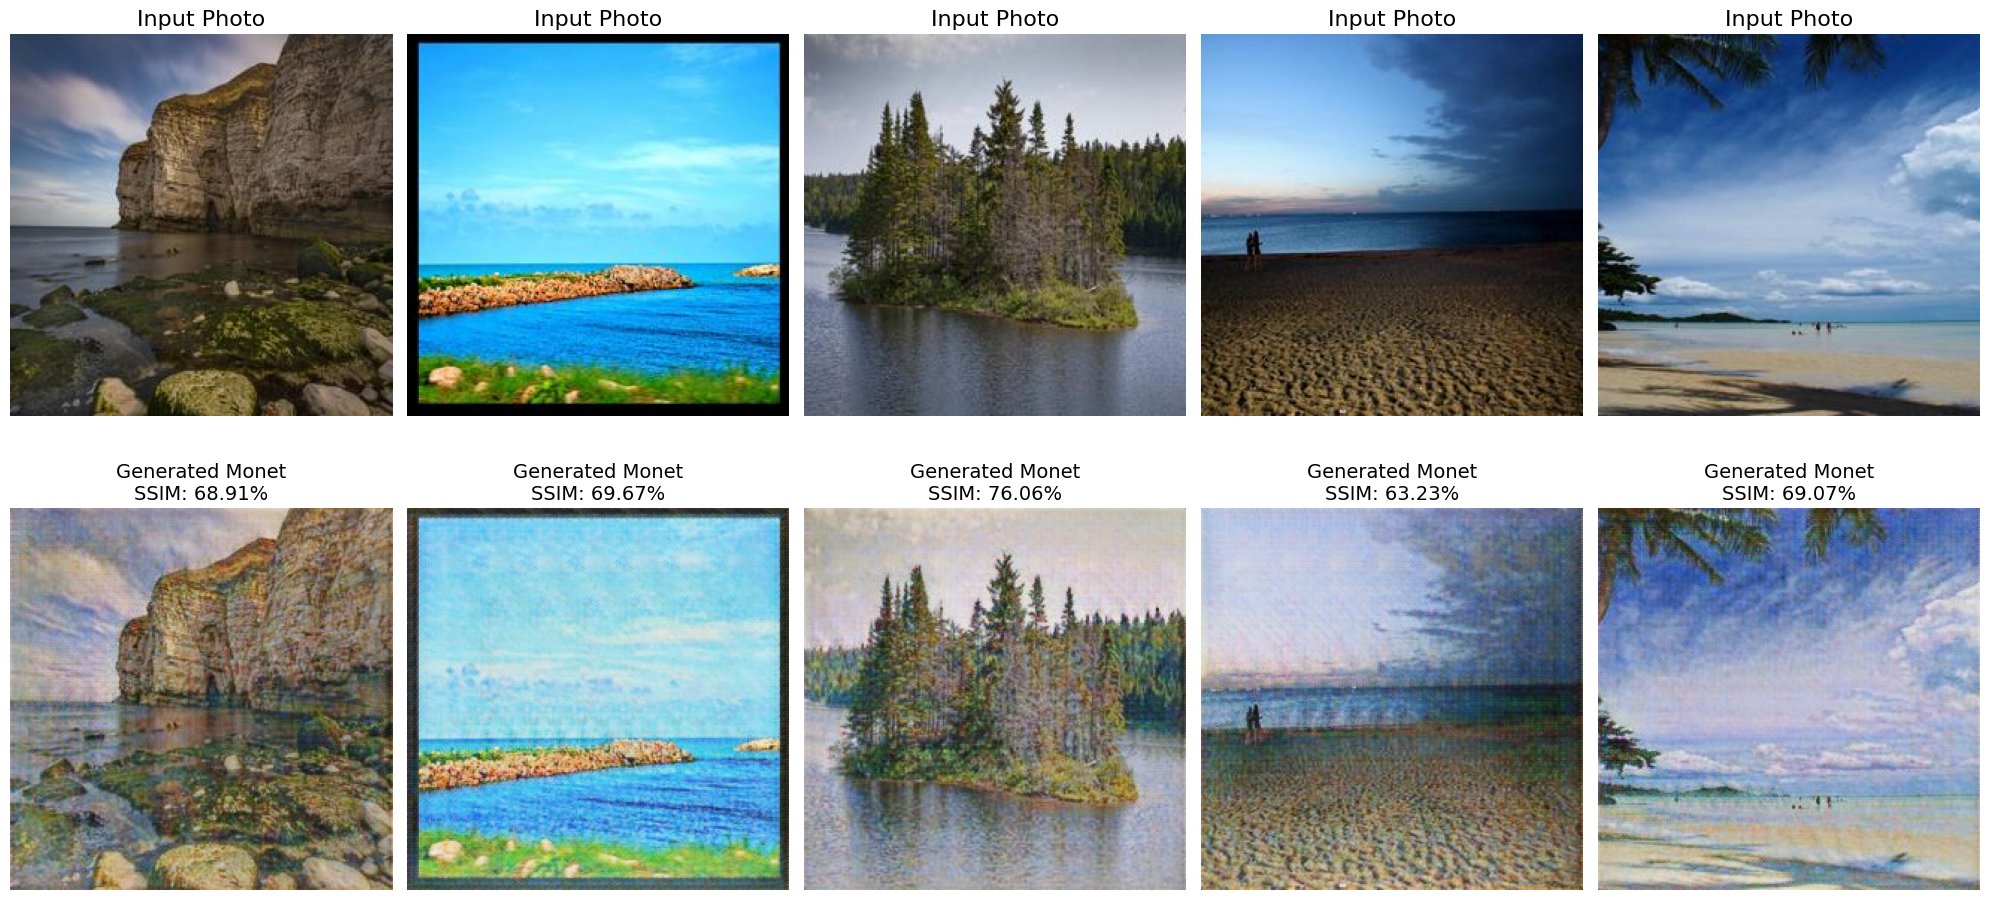

In [6]:
ssim_scores_photo2monet = test_and_display(photo_dir, monet_generator, direction="photo2monet")

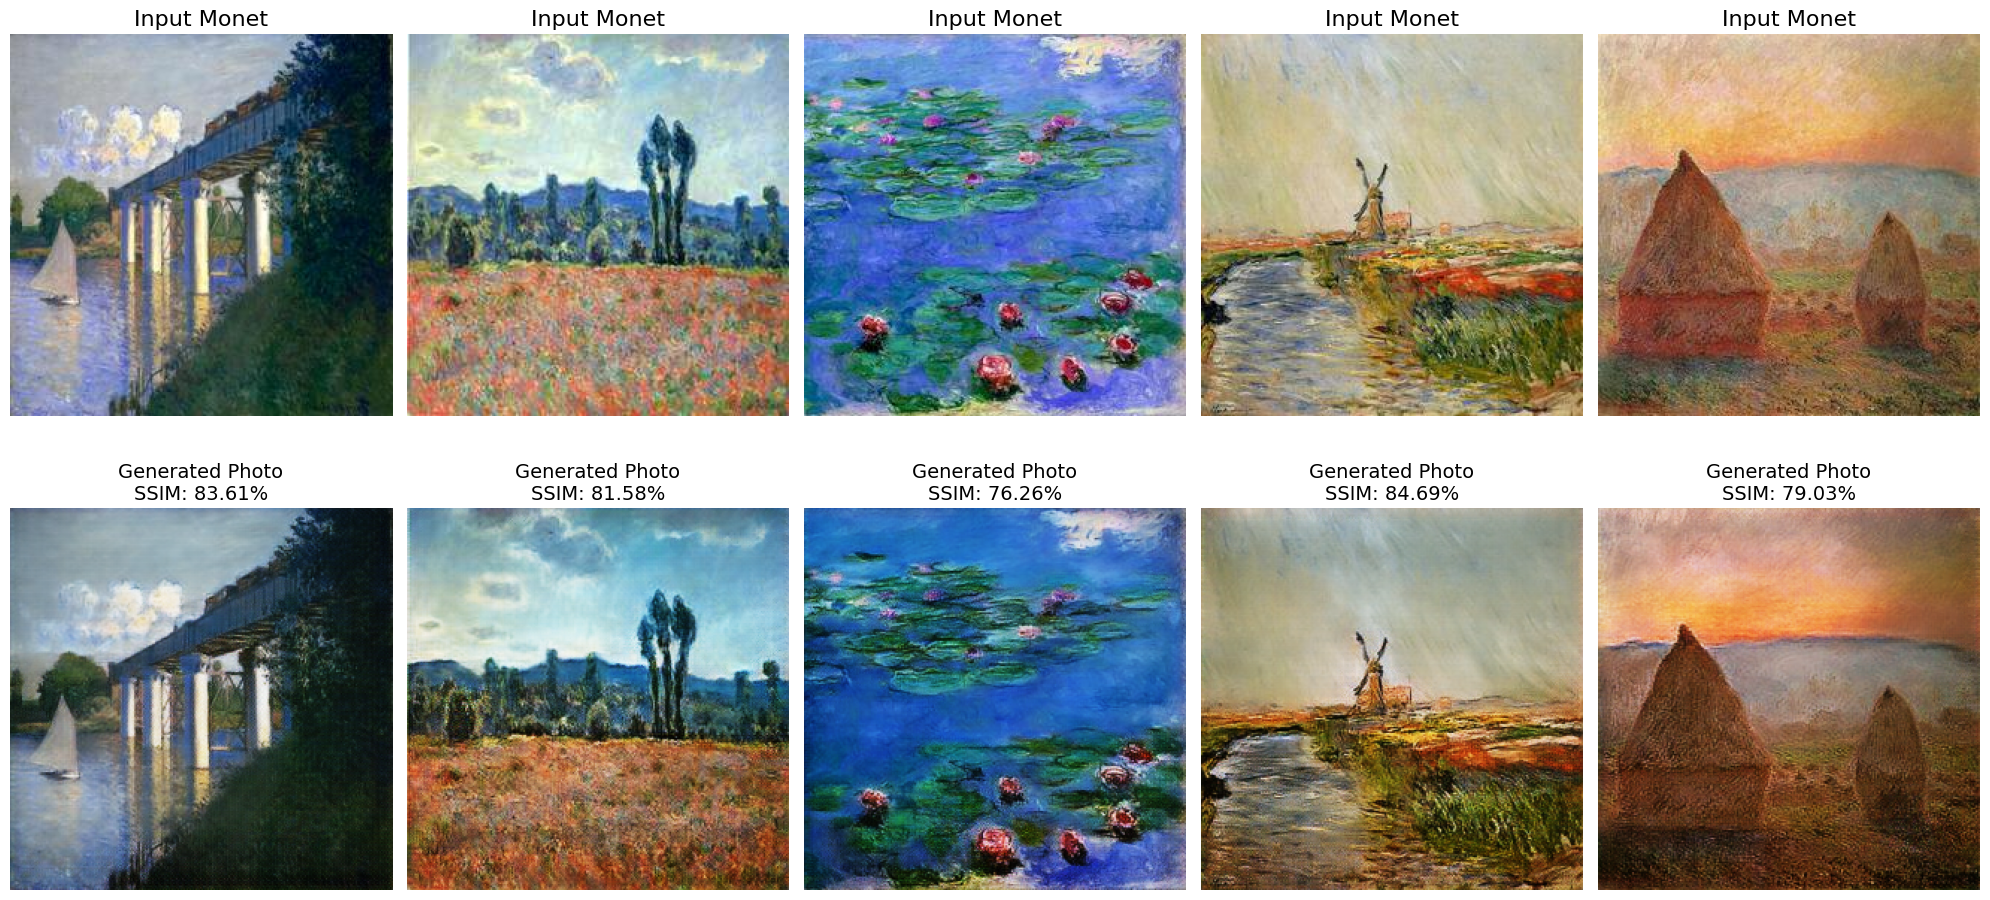

In [7]:
ssim_scores_monet2photo = test_and_display(monet_dir, photo_generator, direction="monet2photo")

In [11]:
output_dir = r"D:\MATTHEW\GITHUB\Cycle GAN Implementation\generated_results"

# Ambil satu file acak dari masing-masing folder
photo_file = random.choice(os.listdir(photo_dir))
monet_file = random.choice(os.listdir(monet_dir))

# Path lengkap
photo_path = os.path.join(photo_dir, photo_file)
monet_path = os.path.join(monet_dir, monet_file)

# Preprocess
photo_tensor = preprocess_image(photo_path)
monet_tensor = preprocess_image(monet_path)

# Generate
generated_monet_tensor = monet_generator(photo_tensor, training=False)
generated_photo_tensor = photo_generator(monet_tensor, training=False)

# Deprocess
photo_image = deprocess_image(photo_tensor[0])
monet_image = deprocess_image(monet_tensor[0])
generated_monet_image = deprocess_image(generated_monet_tensor[0])
generated_photo_image = deprocess_image(generated_photo_tensor[0])

# Simpan ke output_dir
Image.fromarray(photo_image).save(os.path.join(output_dir, "1_photo_original.jpg"))
Image.fromarray(generated_monet_image).save(os.path.join(output_dir, "2_generated_monet.jpg"))
Image.fromarray(monet_image).save(os.path.join(output_dir, "3_monet_original.jpg"))
Image.fromarray(generated_photo_image).save(os.path.join(output_dir, "4_generated_photo.jpg"))